<h1>1. Import Libraries</h1>

In [1]:
import os
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms

<h1>2. Data Preprocessing</h1>

In [7]:
# Function to load and preprocess the dataset
def load_data(csv_file, img_dir, transform=None):
    data = pd.read_csv(csv_file)
    images, labels = [], []

    for idx in range(len(data)):
        img_id = str(data.iloc[idx]['id'])
        if int(img_id) < 663381:
            img_path = os.path.join(img_dir, f"{img_id}.jpg")
            image = Image.open(img_path).convert("RGB")
            
            if transform:
                image = transform(image)
            
            stable_height = int(data.iloc[idx]['stable_height']) - 1  # zero-based class index

            images.append(image)
            labels.append(stable_height)
    
    return images, torch.tensor(labels)


<h1>3. Model Definition</h1>

In [8]:

# Define the model using InceptionV3
class CustomInceptionWithFeatures(nn.Module):
    def __init__(self, num_classes):
        super(CustomInceptionWithFeatures, self).__init__()
        self.inception = models.inception_v3(pretrained=True)
        
        # Modify the fully connected layer to output the desired number of features
        self.inception.fc = nn.Linear(self.inception.fc.in_features, 64)
        
        # Fully connected layers for classification
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # InceptionV3 returns a tuple: (main_output, auxiliary_output). We only need the main output.
        x = self.inception(x)[0]  # Use only the main output
        x = torch.relu(self.fc1(x))  # Pass through the first fully connected layer
        logits = self.fc2(x)  # Get final class logits
        return logits

<h1>4. Training Function</h1>

In [9]:
def train_model(csv_file_path, images_dir_path, num_classes=6, num_epochs=10, batch_size=12, model_save_path="model.pth"):
    # Define image transformations (ensure input size is 299x299 for Inception)
    transform = transforms.Compose([
        transforms.Resize((299, 299)),  # Resize to match Inception's expected input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization used during training
    ])
    
    # Load data
    images, labels = load_data(csv_file_path, images_dir_path, transform)
    dataset = list(zip(images, labels))
    
    # Use DataLoader without the need to stack tensors manually
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model and optimizer
    model = CustomInceptionWithFeatures(num_classes)
    criterion = nn.CrossEntropyLoss()  # For classification
    optimizer = optim.Adam(model.parameters(), lr=0.0002, weight_decay=1e-4)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Save accuracy and loss data
    accuracies = []
    losses = []

    # Training loop
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_correct = 0
        model.train()

        for batch in dataloader:
            images, stable_heights = batch
            images = images.to(device)  # No need to stack, already a tensor
            stable_heights = stable_heights.to(device)

            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, stable_heights)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted_classes = torch.max(logits, 1)
            running_correct += (predicted_classes == stable_heights).sum().item()

        accuracy = running_correct / len(dataloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader.dataset):.4f}, Accuracy: {accuracy:.4f}")
        accuracies.append(accuracy)
        losses.append(running_loss/len(dataloader.dataset))

        # Save the model after every epoch
        torch.save(model.state_dict(), f"{model_save_path}_{epoch+1}.pth")
        print(f"Model saved after Epoch {epoch+1} to {model_save_path}")
    
    return model, accuracies, losses

<h1>7. Running the Training</h1>

In [10]:
def load_model(model_save_path, num_classes):
    # Initialize the model
    model = CustomInceptionWithFeatures(num_classes)
    
    # Load the saved model state dict
    model.load_state_dict(torch.load(model_save_path))
    model.eval()  # Set the model to evaluation mode (important for inference)
    
    return model


In [11]:
csv_file_path = '../COMP90086_2024_Project_train/train.csv'  # Path to your training CSV
images_dir_path = '../COMP90086_2024_Project_train/train'  # Path to your training images
model, accuracies, losses = train_model(csv_file_path, images_dir_path, num_classes=6, model_save_path='inception_models/model') # comment/ uncomment to start training

/Users/qnoens/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/qnoens/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /Users/qnoens/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:23<00:00, 4.66MB/s] 


Epoch [1/10], Loss: 0.1278, Accuracy: 0.3188
Model saved after Epoch 1 to inception_models/model
Epoch [2/10], Loss: 0.1101, Accuracy: 0.4463
Model saved after Epoch 2 to inception_models/model
Epoch [3/10], Loss: 0.0976, Accuracy: 0.5300
Model saved after Epoch 3 to inception_models/model
Epoch [4/10], Loss: 0.0878, Accuracy: 0.5966
Model saved after Epoch 4 to inception_models/model
Epoch [5/10], Loss: 0.0766, Accuracy: 0.6564
Model saved after Epoch 5 to inception_models/model
Epoch [6/10], Loss: 0.0646, Accuracy: 0.7117
Model saved after Epoch 6 to inception_models/model
Epoch [7/10], Loss: 0.0558, Accuracy: 0.7641
Model saved after Epoch 7 to inception_models/model
Epoch [8/10], Loss: 0.0436, Accuracy: 0.8164
Model saved after Epoch 8 to inception_models/model
Epoch [9/10], Loss: 0.0353, Accuracy: 0.8522
Model saved after Epoch 9 to inception_models/model
Epoch [10/10], Loss: 0.0309, Accuracy: 0.8762
Model saved after Epoch 10 to inception_models/model


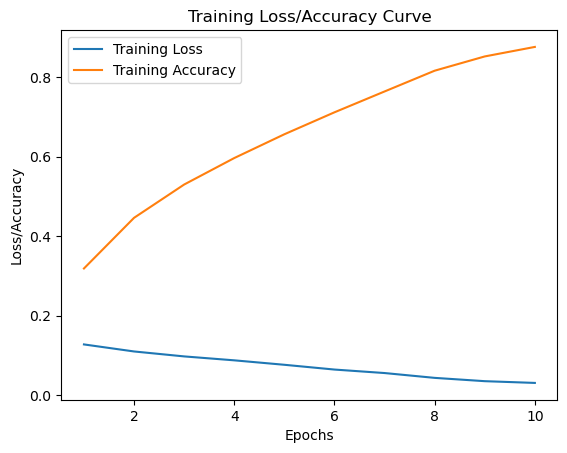

In [12]:
# Plot loss and accuracy curves
import matplotlib.pyplot as plt

epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

plt.plot(epochs, losses, label='Training Loss')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title('Training Loss/Accuracy Curve')
plt.legend()
plt.show()

<h1>Prediction time</h1>

In [15]:
# 2. Preprocess the image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((299, 299)),  # Resize to match Inception's expected input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization used during training
    ])
    
    # Load image using PIL
    image = Image.open(image_path).convert('RGB')
    
    # Apply transformations and return a batch with a single image (unsqueeze to add batch dimension)
    return transform(image).unsqueeze(0)

# 3. Make a prediction
def predict_image(model, image_tensor):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    image_tensor = image_tensor.to(device)
    
    with torch.no_grad():  # Disable gradient calculations for inference
        logits = model(image_tensor)
        predicted_class = torch.argmax(logits, dim=0).item() + 1  # Convert prediction to class (add 1 for class range [1-6])
        # Had to change dim to 0 instead of 1    
    return predicted_class

In [16]:
# For evaluation purposes
val_accuracies = []
for model_id in range(1, 11):
    model_scores = []
    model = load_model(f'inception_models/model_{model_id}.pth', num_classes=6)
    folder_path = '../COMP90086_2024_Project_train/train'
    csv_file = '../COMP90086_2024_Project_train/train.csv'
    data = pd.read_csv(csv_file)

    for idx in range(len(data)):
        img_id = str(data.iloc[idx]['id'])
        if int(img_id) < 663381:
            continue
        image_tensor = preprocess_image(f"{folder_path}/{img_id}.jpg")

        # Predict stable height
        predicted_class = predict_image(model, image_tensor)

        model_scores.append(predicted_class == data.iloc[idx]['stable_height'])
    val_accuracies.append(sum(model_scores) / len(model_scores))
    print(f"Model {model_id} accuracy: {val_accuracies[-1]}")
print(val_accuracies)

/Users/qnoens/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/qnoens/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/m0/9ls3hx_52390h_xy1_hrmzy80000gn/T/ipykernel_26381/403929523.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://g

Model 1 accuracy: 0.42363977485928705


/Users/qnoens/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/qnoens/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/m0/9ls3hx_52390h_xy1_hrmzy80000gn/T/ipykernel_26381/403929523.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://g

Model 2 accuracy: 0.4979362101313321


/Users/qnoens/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/qnoens/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/m0/9ls3hx_52390h_xy1_hrmzy80000gn/T/ipykernel_26381/403929523.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://g

Model 3 accuracy: 0.5410881801125703


/Users/qnoens/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/qnoens/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/m0/9ls3hx_52390h_xy1_hrmzy80000gn/T/ipykernel_26381/403929523.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://g

Model 4 accuracy: 0.5786116322701689


/Users/qnoens/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/qnoens/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/m0/9ls3hx_52390h_xy1_hrmzy80000gn/T/ipykernel_26381/403929523.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://g

Model 5 accuracy: 0.5583489681050656


/Users/qnoens/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/qnoens/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/m0/9ls3hx_52390h_xy1_hrmzy80000gn/T/ipykernel_26381/403929523.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://g

Model 6 accuracy: 0.5842401500938086


/Users/qnoens/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/qnoens/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/m0/9ls3hx_52390h_xy1_hrmzy80000gn/T/ipykernel_26381/403929523.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://g

Model 7 accuracy: 0.6142589118198875


/Users/qnoens/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/qnoens/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/m0/9ls3hx_52390h_xy1_hrmzy80000gn/T/ipykernel_26381/403929523.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://g

Model 8 accuracy: 0.60187617260788


/Users/qnoens/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/qnoens/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/m0/9ls3hx_52390h_xy1_hrmzy80000gn/T/ipykernel_26381/403929523.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://g

Model 9 accuracy: 0.5846153846153846


/Users/qnoens/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/qnoens/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/m0/9ls3hx_52390h_xy1_hrmzy80000gn/T/ipykernel_26381/403929523.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://g

Model 10 accuracy: 0.5969981238273921
[0.42363977485928705, 0.4979362101313321, 0.5410881801125703, 0.5786116322701689, 0.5583489681050656, 0.5842401500938086, 0.6142589118198875, 0.60187617260788, 0.5846153846153846, 0.5969981238273921]


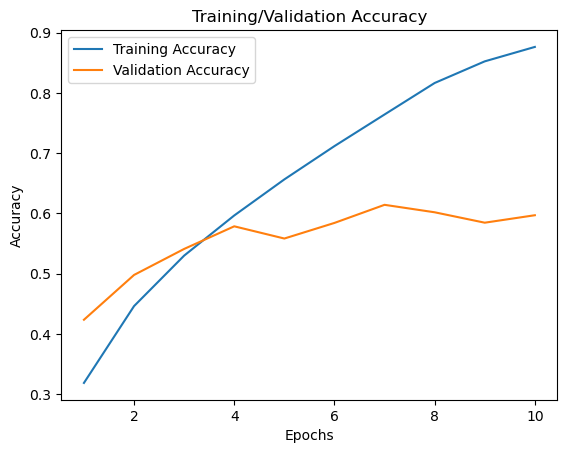

In [17]:
# plot accuracies
import matplotlib.pyplot as plt
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.title('Training/Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.legend()
plt.savefig('inception_accuracy.pdf')
plt.show()

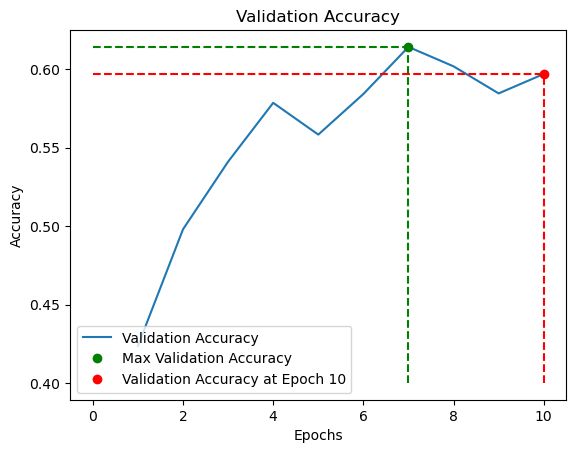

In [18]:
# Make specific plot
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
# draw a horizontal line from the max accuracy on the plot to the x-axis and y-axis, to show the max accuracy but stop the line at the point where the max accuracy was achieved
max_accuracy_epoch = val_accuracies.index(max(val_accuracies)) + 1
plt.plot([max_accuracy_epoch, max_accuracy_epoch], [0.4, max(val_accuracies)], color='g', linestyle='--')
plt.plot([0, max_accuracy_epoch], [max(val_accuracies), max(val_accuracies)], color='g', linestyle='--')
# to the same for the value at epoch 10
plt.plot([10, 10], [0.4, val_accuracies[-1]], color='r', linestyle='--')
plt.plot([0, 10], [val_accuracies[-1], val_accuracies[-1]], color='r', linestyle='--')
# also plot a dot at the max accuracy point
plt.plot(max_accuracy_epoch, max(val_accuracies), 'go', label='Max Validation Accuracy')
plt.plot(10, val_accuracies[-1], 'ro', label='Validation Accuracy at Epoch 10')

plt.legend()
plt.savefig('inception_validation_accuracy.pdf')
plt.show()

In [19]:
model = load_model(f'inception_models/model_{max_accuracy_epoch}.pth', num_classes=6)
folder_path = '../COMP90086_2024_Project_train/train'
csv_file = '../COMP90086_2024_Project_train/train.csv'
data = pd.read_csv(csv_file)
predictions = {"id":[], "stable_height":[]}

for idx in range(len(data)):
    img_id = str(data.iloc[idx]['id'])
    if int(img_id) < 663381:
        continue
    image_tensor = preprocess_image(f"{folder_path}/{img_id}.jpg")

    # Predict stable height
    predicted_class = predict_image(model, image_tensor)

    predictions["id"].append(img_id)
    predictions["stable_height"].append(predicted_class)

/Users/qnoens/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/qnoens/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/m0/9ls3hx_52390h_xy1_hrmzy80000gn/T/ipykernel_26381/403929523.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://g

In [20]:
df = pd.DataFrame(predictions)
df.to_csv("inception_results.csv", index=False)

In [65]:
# 4. Example usage
model_path = 'models/model_8.pth'  # Path to the saved model
folder_path = '../COMP90086_2024_Project_test/test'  # Path to the input image
num_classes = 6  # Number of stable_height classes

# Load model
model = load_model(model_path, num_classes)

predictions = {"id":[], "stable_height":[]}

/var/folders/m0/9ls3hx_52390h_xy1_hrmzy80000gn/T/ipykernel_18201/3234236682.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_p

In [66]:
for image in os.listdir(folder_path):
    image_id = image.strip(".jpg")
    image_tensor = preprocess_image(f"{folder_path}/{image}")

    # Predict stable height
    predicted_class = predict_image(model, image_tensor)

    # update the dict
    predictions["id"].append(image_id)
    predictions["stable_height"].append(predicted_class)

In [67]:
df = pd.DataFrame(predictions)
df.to_csv("test_pred_no_transform.csv", index=False)